# Setup

In [1]:
PATH_ROOT = 'data'
PATH_PARQUET = PATH_ROOT + '/project_datasets'

In [2]:
PATH_OUTPUT = 'output'

In [3]:
!pip install pyarrow

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
%matplotlib inline  

C:\Users\steph\miniconda3\envs\ada\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# 1. Loading speakers data

## Reading wikidata labels

In [5]:
df_wikidata_labels = pd.read_csv(PATH_PARQUET + '/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
df_wikidata_labels.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


## Reading speakers parquet file

In [6]:
df_speakers = pd.read_parquet(PATH_PARQUET + '/speaker_attributes.parquet')
df_speakers.set_index(keys='id', inplace=True)
df_speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,George Washington,"[Q698073, Q697949]",item,[Q682443]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Douglas Adams,None,item,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Paul Otlet,None,item,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Diego Velázquez,None,item,None


In [7]:
df_speakers_cleaned = df_speakers.dropna()
print('Total number of speakers : ', len(df_speakers))
print('Total number of speakers with filled attributes : ', len(df_speakers_cleaned))
print('{} rows dropped'.format(len(df_speakers) - len(df_speakers_cleaned)))

Total number of speakers :  9055981
Total number of speakers with filled attributes :  3
9055978 rows dropped


As we can see that dropping all speakers with undefined attributes is unrealistic to work with, since we're only left with 3 speakers with all their attributes defined to work with. We're going to have to some fine-grained filtering of undefined values column wise instead of on whole rows (all attributes).

## 2 - Merging speakers attributes qids with wikidata labels

In [8]:
attributes_columns = ['date_of_birth', 'nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']

# Let's first explode their attributes
for col in attributes_columns:
    df_speakers = df_speakers.explode(col)
    
df_speakers.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q82955,Q327591,None,George Washington,Q698073,item,Q682443
Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q82955,Q327591,None,George Washington,Q697949,item,Q682443
Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q189290,Q327591,None,George Washington,Q698073,item,Q682443
Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q189290,Q327591,None,George Washington,Q697949,item,Q682443
Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,Q161885,Q6581097,1395141751,None,W000178,Q131512,Q327591,None,George Washington,Q698073,item,Q682443


#### Quick stop before proceeding

Before we continue, we need to convert the date of birth to something meaningful like the speaker's age.

In [11]:
def normalize_date_of_birth(date):
    '''
    Normalize the date of birth format of our speakers. Currently the format is (+/-)YYYY-MM-DDTHH:MM:SS: Z.
    We'll convert it simply to YYYY-MM-DD. However the date sometimes has month or day value of 0, and hence 
    needs further sanitization, and in that case we just output the year.
    
    Params: 
        date: the date
    returns:
        the date formatted as YYYY:MM:DD
    '''
    if date is not None:
        birth_date = date[1:11]
        year, month, day = birth_date[0:4], birth_date[5:7], birth_date[8:11]
        if month == '00' or day == '00':
            return year
        else:
            return birth_date
    else:
        return date

test_data = '+1732-02-22T00:00:00Z'
display(normalize_date_of_birth(test_data))
test_data_invalid_month = '+1732-00-22T00:00:00Z'
display(normalize_date_of_birth(test_data_invalid_month))

'1732-02-22'

'1732'

In [16]:
# Normalize date of birth into a new column 'age' in which we'll calculate the age of the speaker
# and then convert it to datetime instance
df_speakers['age'] = pd.to_datetime(df_speakers.date_of_birth.apply(normalize_date_of_birth), errors='coerce')
df_speakers.age.head()

id
Q23   1732-02-22
Q23   1732-02-22
Q23   1732-02-22
Q23   1732-02-22
Q23   1732-02-22
Name: date_of_birth, dtype: datetime64[ns]

In [ ]:
def compute_age(date_of_birth):
    now = pd.Timestamp('now')
    age = date_o

In [43]:
# Calculate the age by computing the difference between now and their birth dates.
now = pd.Timestamp('now')
df_speakers.age = (now.year - df_speakers.age.year)
df_speakers.age.head()

60.38356164383562

In [48]:
df_speakers[df_speakers.label == 'Donald Trump'][['date_of_birth', 'age']]

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,normalized_dob
id,,,,,,,,,,,,,,,
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",+1946-06-14T00:00:00Z,Q30,Q6581097,1395141850,None,None,Q911554,Q29468,Q787674,Donald Trump,Q699872,item,Q178169,1946-06-14
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",+1946-06-14T00:00:00Z,Q30,Q6581097,1395141850,None,None,Q911554,Q29468,Q787674,Donald Trump,Q22923830,item,Q178169,1946-06-14
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",+1946-06-14T00:00:00Z,Q30,Q6581097,1395141850,None,None,Q911554,Q29468,Q787674,Donald Trump,Q38051523,item,Q178169,1946-06-14
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",+1946-06-14T00:00:00Z,Q30,Q6581097,1395141850,None,None,Q911554,Q1897793,Q787674,Donald Trump,Q699872,item,Q178169,1946-06-14
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",+1946-06-14T00:00:00Z,Q30,Q6581097,1395141850,None,None,Q911554,Q1897793,Q787674,Donald Trump,Q22923830,item,Q178169,1946-06-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",+1946-06-14T00:00:00Z,Q30,Q6581097,1395141850,None,None,Q1062083,Q29468,Q787674,Donald Trump,Q38051523,item,Q178169,1946-06-14
Q27947481,"[Donald L. Trump, Donald Lynn Trump, Skip Trum...",+1945-07-31T00:00:00Z,Q30,Q6581097,1392088288,None,None,Q39631,None,Q913404,Donald Trump,None,item,None,1945-07-31
Q27947481,"[Donald L. Trump, Donald Lynn Trump, Skip Trum...",+1945-07-31T00:00:00Z,Q30,Q6581097,1392088288,None,None,Q16062369,None,Q913404,Donald Trump,None,item,None,1945-07-31


In [49]:
pd.to_datetime('1990-02-01')

Timestamp('1990-02-01 00:00:00')

Of course ages are just indicative, we can have people like president George Washington who are over 200 years old.

#### Now let's merge attributes with their wikidata labels

In [9]:
df_speakers_labeled = df_speakers.copy()

for col in attributes_columns:
    df_speakers_labeled = df_speakers_labeled.merge(df_wikidata_labels, left_on=col, right_index=True, how='left')
    df_speakers_labeled[col] = df_speakers_labeled['Label']
    df_speakers_labeled.drop(columns=['Label', 'Description'], inplace=True)

In [10]:
df_speakers_labeled.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],Great Britain,male,1395141751,NaN,W000178,farmer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church


Now we have a row per speaker for every combination of his attributes. This might be biased for speakers with a lot of attributes (e.g. several occupations, ethnic_group, etc...).

In [20]:
display(df_speakers_labeled.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(df_speakers_labeled)))

aliases               object
date_of_birth         object
nationality           object
gender                object
lastrevid              int64
ethnic_group          object
US_congress_bio_ID    object
occupation            object
party                 object
academic_degree       object
label                 object
candidacy             object
type                  object
religion              object
dtype: object

Length of final labeled speakers dataframe 11818189


## 3 - Save result to disk for quick future retrieval

In [12]:
df_speakers_labeled.to_csv(PATH_OUTPUT + '/speakers_labeled.csv', index=False)

## 4 - Explore the speakers data (Continue work from here)

Let's do some quick analysis on the speakers' professions. First retrieve our dataframe saved in csv.

In [5]:
retrieved_labeled_speakers = pd.read_csv(PATH_OUTPUT + '/speakers_labeled.csv')
retrieved_labeled_speakers.head()

C:\Users\steph\miniconda3\envs\ada\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
0,['Washington' 'President Washington' 'G. Washi...,['+1732-02-22T00:00:00Z'],Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church
1,['Washington' 'President Washington' 'G. Washi...,['+1732-02-22T00:00:00Z'],Great Britain,male,1395141751,NaN,W000178,politician,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church
2,['Washington' 'President Washington' 'G. Washi...,['+1732-02-22T00:00:00Z'],Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church
3,['Washington' 'President Washington' 'G. Washi...,['+1732-02-22T00:00:00Z'],Great Britain,male,1395141751,NaN,W000178,military officer,independent politician,NaN,George Washington,1788–89 United States presidential election,item,Episcopal Church
4,['Washington' 'President Washington' 'G. Washi...,['+1732-02-22T00:00:00Z'],Great Britain,male,1395141751,NaN,W000178,farmer,independent politician,NaN,George Washington,1792 United States presidential election,item,Episcopal Church


In [6]:
display(retrieved_labeled_speakers.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(retrieved_labeled_speakers)))

aliases               object
date_of_birth         object
nationality           object
gender                object
lastrevid              int64
ethnic_group          object
US_congress_bio_ID    object
occupation            object
party                 object
academic_degree       object
label                 object
candidacy             object
type                  object
religion              object
dtype: object

Length of final labeled speakers dataframe 11818189


### 4.1 - Speakers occupations

Now let's see the distribution of the speakers' occupations.

In [7]:
grouped_by_occupations = retrieved_labeled_speakers.groupby(by='occupation').label.agg(['count'])
grouped_by_occupations = grouped_by_occupations.sort_values(by='count', ascending=False)
grouped_by_occupations.head()

,count
occupation,
researcher,1695817
politician,744803
association football player,329054
writer,295335
actor,285794


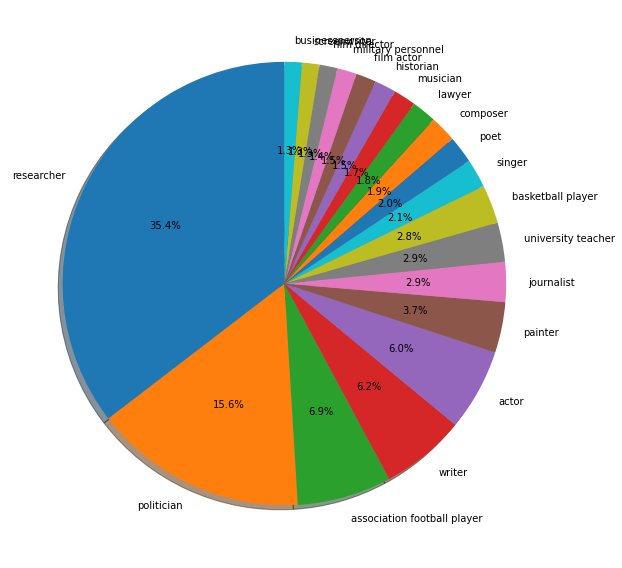

In [8]:
# Plot the distribution of the top 20 occupations
fig, ax = plt.subplots(figsize =  (14, 8))
ax.pie(grouped_by_occupations[:20]['count'], labels=grouped_by_occupations[:20].index, autopct='%1.1f%%',
        shadow=True, startangle=90)

fig.tight_layout()

Someone like Donald Trump has a lot of occupations, which means he's going to have a lot of rows dedicated to him in the dataframe, since we exploded the multi-values attributes. (This can be **problematic when training our model**)

In [9]:
# Some examples of prominent US politicans
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Donald Trump'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Barack Obama'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Alexandria Ocasio-Cortez'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Hillary Clinton'].occupation.unique())
display(retrieved_labeled_speakers[retrieved_labeled_speakers.label == 'Bill Clinton'].occupation.unique())

array(['business magnate', 'investor', 'restaurateur',
       'non-fiction writer', 'entrepreneur', 'politician',
       'businessperson', 'real estate developer', 'game show host',
       'real estate entrepreneur', 'television producer', 'film producer',
       'writer', 'actor', 'chief executive officer',
       'television presenter', 'conspiracy theorist', 'billionaire',
       'physician', 'oncologist'], dtype=object)

array(['politician', 'lawyer', 'political writer', 'community organizer',
       'statesperson'], dtype=object)

KeyboardInterrupt: 

### 4.2 - Speaker's gender 

In [ ]:
grouped_by_gender = retrieved_labeled_speakers.groupby(by='gender').label.agg(['count'])
grouped_by_gender = grouped_by_gender.sort_values(by='count', ascending=False)
grouped_by_gender.head()

In [ ]:
not_male_mask = grouped_by_gender.index != 'male' 
not_female_mask = grouped_by_gender.index != 'female'
len(grouped_by_gender[not_male_mask & not_female_mask]) / len(grouped_by_gender)

The majority of speakers in the Quotebank are male (almost 70%). All other genders consitute about 5% of the speakers.

### 4.3 - Speaker's age

So far we've had the speakers date of birth. Let's convert that to age.

array(["['+1732-02-22T00:00:00Z']"], dtype=object)

## 5 - Constructing a feature matrix

If we're trying to train a model using our speakers attributes, we're going to have to think of a way to construct a feature matrix. The issue is a lot of the attributes of the speakers are categorical. One way to construct features from those is to one-hot encode them.